In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

import sys, os
import pandas as pd
from pandas import DataFrame
import datetime
import numpy as np 
import scipy as sc
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold,cross_val_score, learning_curve, cross_validate,train_test_split,GridSearchCV 
from sklearn.feature_selection import RFE, RFECV 
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb

In [2]:
df = pd.concat(map(pd.read_csv, ['football_data.csv']),ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Columns: 136 entries, AF5 to DPB10w
dtypes: float64(125), int64(6), object(5)
memory usage: 4.7+ MB


In [3]:
def ent(data):
    p_data= data.value_counts()/len(data)
    entropy=sc.stats.entropy(p_data)
    return entropy

In [4]:
#Czy entropia ma zwiazek z korelacja ??
for column in list(df.columns.values):
    print (column+':')
    print (ent(df[column]))

AF5:
5.519485860698547
AGD10:
2.727213884228698
AGD20:
3.012539158417561
AGD30:
3.1447134046565113
AGD38:
3.1690970914430445
AGD5:
2.389126368353644
AGL10:
2.6163332144363025
AGL20:
3.0280281104520994
AGL30:
3.230091473812765
AGL38:
3.276989799028176
AGL5:
2.2373595381062934
AGS10:
2.663236778567315
AGS20:
3.071922448360029
AGS30:
3.2578763004357225
AGS38:
3.299482758331971
AGS5:
2.2763915612192425
ALF5:
1.828169151862762
ALM1:
1.0802761248911847
ALM2:
1.0957334799392542
ALM3:
1.097904449902798
ALM4:
1.0985186226621377
ALM5:
1.0979107913570179
AP10:
3.2012447055677438
AP20:
3.798444246636535
AP30:
4.0774365027630095
AP38:
4.140764456689926
AP5:
2.6047434517098385
AwayTeam:
3.4432972379823243
DP10:
3.3459008882882753
DP20:
3.77402349383147
DP30:
3.9514572754743518
DP38:
3.984147184573459
DP5:
2.907663560017719
Day:
3.415643254166155
DaysFromToday:
4.954938730216311
FTR:
1.0623297190258203
GD10:
2.965880054161567
GD20:
3.2746476640885325
GD30:
3.40262886967229
GD38:
3.423373326169088
GD5

In [5]:
def code_string_values(df):
    team_code = df.AwayTeam.unique()
    team_code = dict(zip(team_code, range(len(team_code))))
    df = df.applymap(lambda s: team_code.get(s) if s in team_code else s)
    
    form_code = df.HF5.unique()
    form_code2 = df.AF5.unique()
    form_code = np.concatenate((form_code, form_code2))
    
    form_code= dict(zip(form_code, range(len(form_code))))
    
    to_code = df.copy()
    to_code = to_code.applymap(lambda s: form_code.get(s) if s in form_code else s)
    
    df['HF5'] = to_code['HF5']
    df['AF5'] = to_code['AF5']

    return df

df = code_string_values(df)

In [6]:
df_copy = df.copy()

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(y_test.value_counts()['H']/len(y_test))
print(y_train.value_counts()['H']/len(y_train))
print('\n')
print(y_test.value_counts()['D']/len(y_test))
print(y_train.value_counts()['D']/len(y_train))
print('\n')
print(y_test.value_counts()['A']/len(y_test))
print(y_train.value_counts()['A']/len(y_train))

0.4791666666666667
0.45805921052631576


0.2324561403508772
0.26096491228070173


0.2883771929824561
0.28097587719298245


In [7]:
df_copy = df.copy()

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=2019)

In [8]:
classifier = LogisticRegression() 
classifier = classifier.fit(X_train,y_train)
print('Accuracy of logistic regression classifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))

Accuracy of logistic regression classifier on test validation set: 0.533


In [9]:
X = X_train.copy()
y = y_train.copy()

for c in range(5):
    print("seed ",c)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=c)

    classifier = LogisticRegression()
    classifier.fit(Xtrain, ytrain)
    print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(classifier.score(Xtrain, ytrain)))
    print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(classifier.score(Xtest, ytest)))

seed  0
Accuracy of logistic regression classifier on train set: 0.5433
Accuracy of logistic regression classifier on test set: 0.4913
seed  1
Accuracy of logistic regression classifier on train set: 0.5366
Accuracy of logistic regression classifier on test set: 0.5105
seed  2
Accuracy of logistic regression classifier on train set: 0.5311
Accuracy of logistic regression classifier on test set: 0.5151
seed  3
Accuracy of logistic regression classifier on train set: 0.5441
Accuracy of logistic regression classifier on test set: 0.4922
seed  4
Accuracy of logistic regression classifier on train set: 0.5468
Accuracy of logistic regression classifier on test set: 0.4959


In [10]:
X = X_train.copy()
y = y_train.copy()

classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation sets is %2.3f" % scores['test_score'].mean())

ytest = DataFrame(y_validation)
ytrain = DataFrame(y_train)

for i in range(10):
    print('Number of estimator ',i)
    print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(scores['test_score'][i]))
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(scores['estimator'][i].score(X_validation, ytest)))
    print('\n')

LogisticRegression average accuracy for cross-validation sets is 0.510
Number of estimator  0
Accuracy of logistic regression classifier on validation set: 0.50
Accuracy of logistic regression classifier on test set: 0.52


Number of estimator  1
Accuracy of logistic regression classifier on validation set: 0.54
Accuracy of logistic regression classifier on test set: 0.54


Number of estimator  2
Accuracy of logistic regression classifier on validation set: 0.54
Accuracy of logistic regression classifier on test set: 0.53


Number of estimator  3
Accuracy of logistic regression classifier on validation set: 0.48
Accuracy of logistic regression classifier on test set: 0.54


Number of estimator  4
Accuracy of logistic regression classifier on validation set: 0.53
Accuracy of logistic regression classifier on test set: 0.53


Number of estimator  5
Accuracy of logistic regression classifier on validation set: 0.54
Accuracy of logistic regression classifier on test set: 0.53


Number of e

In [11]:
def normalize(df):
    colums_to_normalization = list(df.columns.values)
    df[colums_to_normalization] = df[colums_to_normalization].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))
    return df

In [12]:
X = X_train.copy()
y = y_train.copy()

X = normalize(X)

classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

LogisticRegression average accuracy for cross-validation test set is 0.515


In [13]:
for j in range(5):
    for i in range(2):
        X = X_train.copy()
        y = y_train.copy()
        if i == 1:
            X = normalize(X)
            print("After normaliazation :")
        else :
            print("Before normaliazation :")

        classifier = LogisticRegression()
        scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, n_jobs=-1)
        print("Average fitting time %2.3f" % scores['fit_time'].mean())
    print('\n')

Before normaliazation :
Average fitting time 7.499
After normaliazation :
Average fitting time 1.289


Before normaliazation :
Average fitting time 7.007
After normaliazation :
Average fitting time 1.274


Before normaliazation :
Average fitting time 7.818
After normaliazation :
Average fitting time 1.188


Before normaliazation :
Average fitting time 7.864
After normaliazation :
Average fitting time 1.245


Before normaliazation :
Average fitting time 6.710
After normaliazation :
Average fitting time 1.139




In [14]:
def remove_outliers(column):
    elements = np.array(df[column])
    
    mean = np.mean(elements, axis=0)
    sd = np.std(elements, axis=0)
    
    final_list = [x for x in np.array(df[column]) if (x > mean - 3 * sd)]
    return [x for x in final_list if (x < mean + 3 * sd)]

def remove_outliers_for_FTR(df_copy):
    df_copy_Home = df_copy[df_copy['FTR'].isin(['H'])]
    df_copy_Draw = df_copy[df_copy['FTR'].isin(['D'])]
    df_copy_Away = df_copy[df_copy['FTR'].isin(['A'])]

    columns = ['AGD5', 'AGL5', 'AGS20', 'AGS30', 'GD38', 'HGD10', 'HGS10', 'HGS30', 'HGS38', 'LSTPA', 'LSTPD']

    for c in columns :
        df_copy_Home = df_copy_Home[df_copy_Home[c].isin(remove_outliers(c))]
        df_copy_Draw = df_copy_Draw[df_copy_Draw[c].isin(remove_outliers(c))]
        df_copy_Away = df_copy_Away[df_copy_Away[c].isin(remove_outliers(c))]
    
    filepaths = [df_copy_Home,df_copy_Draw,df_copy_Away]
    return pd.concat(filepaths,ignore_index=True)

In [15]:
def print_example_scatter(df,X):
    plt.scatter(df['FTR'], df['AGD5'], color= 'red')
    plt.scatter(X['FTR'], X['AGD5'],alpha=0.25)
    plt.show()

Numbers of rows before removing outliers :  3648
Numbers of rows after removing outliers :  3472


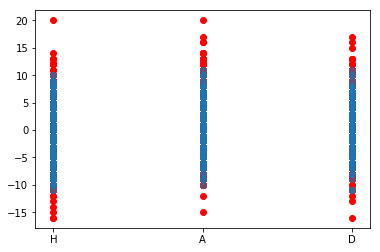

LogisticRegression average accuracy for cross-validation test set is 0.509


In [16]:
X = X_train.copy()
y = y_train.copy()
X['FTR'] = y
print("Numbers of rows before removing outliers : ",len(X))
X = remove_outliers_for_FTR(X)
print("Numbers of rows after removing outliers : ",len(X))
print_example_scatter(df,X)
y = X['FTR']

X = X[X.columns.difference(['FTR'])]
X = normalize(X)
classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

In [17]:
for c in list(X_train):
    print(c)
    print(df['FTR'].corr(df[c],method='spearman'))

AF5
0.004979027514580511
AGD10
-0.15912610185141335
AGD10w
-0.1530766346171582
AGD20
-0.1777282267681726
AGD20w
-0.1741234896154915
AGD30
-0.1770418226420572
AGD30w
-0.1759402079896938
AGD38
-0.17451746594407744
AGD38w
-0.1739259978406772
AGD5
-0.14379031291031827
AGD5w
-0.13639457123842225
AGL10
0.04211329066505488
AGL10w
0.017862879120818922
AGL20
0.038928256916214515
AGL20w
0.041147524732046296
AGL30
0.0316747622890104
AGL30w
0.05689733592956429
AGL38
0.029300121480683634
AGL38w
0.05800438535086869
AGL5
0.044147852705395785
AGL5w
0.017900960266200843
AGS10
-0.0716153381084135
AGS10w
-0.06778341370632035
AGS20
-0.060599161772657006
AGS20w
-0.08974372050642856
AGS30
-0.04775455921493343
AGS30w
-0.0956529433462136
AGS38
-0.0448492755928798
AGS38w
-0.09466475272545767
AGS5
-0.07551303519431414
AGS5w
-0.05935927157400758
ALF5
-0.09770274060091318
ALM1
-0.11442386071744695
ALM2
-0.0872422042024767
ALM3
-0.08498390186649722
ALM4
-0.09281164906098396
ALM5
-0.08342253735774864
AP10
-0.148925

In [18]:
correlation_columns = ['DP20','DP30','DP38','GD10','GD20','GD30','GD38','LSTPD']
X = X_train.copy()
y = y_train.copy()
X = X[correlation_columns]

classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

LogisticRegression average accuracy for cross-validation test set is 0.527


In [19]:
def get_RFE_features(estimator,X,y,df_copy,number_of_features):
    rfe = RFE(estimator, number_of_features)
    fit = rfe.fit(X, y)
    f = rfe.get_support(1)
    print(rfe.ranking_,"\n")
    print(X.columns[f],"\n")

    X = X[X.columns[f]]
    return X[X.columns.difference(['FTR'])],rfe

In [20]:
X = X_train.copy()
y = y_train.copy()

X = normalize(X)

X,rfe = get_RFE_features(LogisticRegression(),X,y,df_copy,10)

classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

[ 98   2  86  97  76 123  65  10  30   4  40  12  63  43  79  64 125  44
   3  31  77  50  69  49  29  74   1  56  89  32   1  21  67 117 124 115
 114  23  51   1  70  35  24  36  84  91  96  19  75  71   1  73   1  26
 106  85 112  25  14  53   1  11  27  22  45  33  15   1  94  37  59 116
  57 110 126 118  61 119 102  58  38 122  99  68  80 120  54 108  60  72
  88 121  62  48   6  47   7  90  78 111  28  81  41  82 107  42   1  93
  13  55  95  34 113 105 104 103 101  39  92   5  20   1   8  83  46 109
   9  16 100  17   1  18  66  52  87] 

Index(['AGS30w', 'AGS5w', 'AP20', 'DP20', 'DP30', 'DPB20', 'DPB5w', 'HGS30w',
       'HP30', 'LSTPD'],
      dtype='object') 

LogisticRegression average accuracy for cross-validation test set is 0.527


Optimal number of features: 13
Selected features: ['AGD10', 'AGD5', 'AGL38w', 'AGS30w', 'AGS5w', 'AP20', 'DP20', 'DP30', 'DPB20', 'DPB5w', 'HGS30w', 'HP30', 'LSTPD']
LogisticRegression average accuracy for cross-validation test set is 0.526


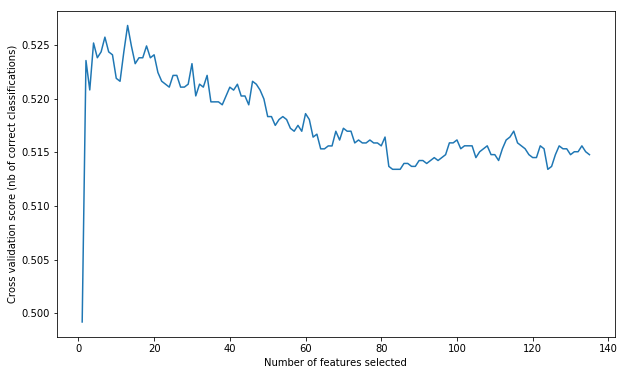

In [21]:
X = X_train.copy()
y = y_train.copy()
X = normalize(X)

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))
rfecv_selected_featues = rfecv.support_
X = X[X.columns[rfecv.support_]]

classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [22]:
X = X_train.copy()
y = y_train.copy()

X = normalize(X[X.columns.difference(['FTR'])])

X = X[X.columns[rfecv_selected_featues]]

param_grid = [
  {'penalty': ['l2'], 'solver': [ 'newton-cg','lbfgs', 'sag', 'saga'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr', 'multinomial'], 'class_weight' : [None, 'balanced']},
    
  {'penalty': ['l2'], 'solver': ['liblinear'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr'], 'class_weight' : [None, 'balanced']},
    
  {'penalty': ['l1'], 'solver': ['saga'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr', 'multinomial'], 'class_weight' : [None, 'balanced']},
 ]

model_lr = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=10)
model_lr.fit(X, y)
clf = model_lr.best_estimator_
print('The best found score and model:')
print (model_lr.best_score_, model_lr.best_params_) 

The best found score and model:
0.528234649122807 {'C': 10, 'class_weight': None, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'saga'}


In [23]:
X = X_train.copy()
y = y_train.copy()

X = normalize(X[X.columns.difference(['FTR'])])

X = X[X.columns[rfecv_selected_featues]]

classifier = LogisticRegression(C= 1,penalty= 'l2',class_weight= None, multi_class= 'ovr',solver= 'newton-cg') 
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

LogisticRegression average accuracy for cross-validation test set is 0.526


In [24]:
df_copy = df.copy()

y = df_copy['FTR']

df_copy = df_copy[df_copy.columns.difference(['FTR'])]
df_copy = df_copy[df_copy.columns[rfecv_selected_featues]]

df_copy = normalize(df_copy[df_copy.columns.difference(['FTR'])])

X = df_copy[df_copy.columns.difference(['FTR'])]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=2019)

In [25]:
classifier = LogisticRegression(C= 1,penalty= 'l2',class_weight= None, multi_class= 'ovr',solver= 'liblinear') 
classifier = classifier.fit(X_train,y_train)
print('Accuracy of logistic regression classifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of logistic regression classifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

Accuracy of logistic regression classifier on test validation set: 0.538
Accuracy of logistic regression classifier on train set: 0.526

 Confusion matrix: 
[[138   0 109]
 [ 78   0 155]
 [ 78   1 353]] 

Classification report: 
              precision    recall  f1-score   support

           A       0.47      0.56      0.51       247
           D       0.00      0.00      0.00       233
           H       0.57      0.82      0.67       432

   micro avg       0.54      0.54      0.54       912
   macro avg       0.35      0.46      0.39       912
weighted avg       0.40      0.54      0.46       912



<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

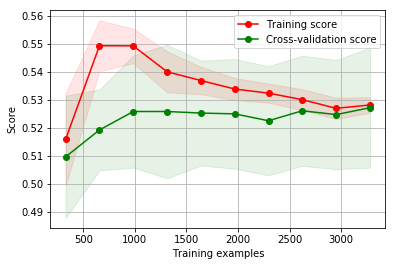

In [26]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=10, scoring='accuracy', obj_line=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    if obj_line:
        plt.axhline(y=obj_line, color='blue')

    plt.legend(loc="best")
    return plt

plot_learning_curve(LogisticRegression(C= 1,penalty= 'l1',class_weight= None, multi_class= 'ovr',solver= 'saga') , X_train, y_train )

In [8]:
df_copy = df.copy()

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=2019)

In [9]:
classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.522


In [10]:
X = X_train.copy()
y = y_train.copy()

for c in range(5):
    print("seed ",c)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=c)

    classifier = xgb.XGBClassifier(nthread =-1)
    classifier.fit(Xtrain, ytrain)
    print('Accuracy of ',classifier.__class__.__name__,' classifier on train set: {:.4f}'.format(classifier.score(Xtrain, ytrain)))
    print('Accuracy of ',classifier.__class__.__name__,' classifier on test set: {:.4f}'.format(classifier.score(Xtest, ytest)))

seed  0
Accuracy of  XGBClassifier  classifier on train set: 0.6694
Accuracy of  XGBClassifier  classifier on test set: 0.4895
seed  1
Accuracy of  XGBClassifier  classifier on train set: 0.6620
Accuracy of  XGBClassifier  classifier on test set: 0.5151
seed  2
Accuracy of  XGBClassifier  classifier on train set: 0.6851
Accuracy of  XGBClassifier  classifier on test set: 0.5014
seed  3
Accuracy of  XGBClassifier  classifier on train set: 0.6451
Accuracy of  XGBClassifier  classifier on test set: 0.5132
seed  4
Accuracy of  XGBClassifier  classifier on train set: 0.6761
Accuracy of  XGBClassifier  classifier on test set: 0.4941


In [30]:
X = X_train.copy()
y = y_train.copy()

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation sets is %2.3f" % scores['test_score'].mean())

ytest = DataFrame(y_validation)
ytrain = DataFrame(y_train)

for i in range(10):
    print('Number of estimator ',i)
    print('Accuracy of ',classifier.__class__.__name__,' classifier on validation set: {:.2f}'.format(scores['test_score'][i]))
    print('Accuracy of ',classifier.__class__.__name__,' classifier on test set: {:.2f}'.format(scores['estimator'][i].score(X_validation, ytest)))
    print('\n')

XGBClassifier average accuracy for cross-validation sets is 0.522
Number of estimator  0
Accuracy of  XGBClassifier  classifier on validation set: 0.53
Accuracy of  XGBClassifier  classifier on test set: 0.55


Number of estimator  1
Accuracy of  XGBClassifier  classifier on validation set: 0.52
Accuracy of  XGBClassifier  classifier on test set: 0.53


Number of estimator  2
Accuracy of  XGBClassifier  classifier on validation set: 0.56
Accuracy of  XGBClassifier  classifier on test set: 0.54


Number of estimator  3
Accuracy of  XGBClassifier  classifier on validation set: 0.51
Accuracy of  XGBClassifier  classifier on test set: 0.55


Number of estimator  4
Accuracy of  XGBClassifier  classifier on validation set: 0.50
Accuracy of  XGBClassifier  classifier on test set: 0.55


Number of estimator  5
Accuracy of  XGBClassifier  classifier on validation set: 0.53
Accuracy of  XGBClassifier  classifier on test set: 0.56


Number of estimator  6
Accuracy of  XGBClassifier  classifier on

In [31]:
X = X_train.copy()
y = y_train.copy()

X = normalize(X)

model = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.522


In [32]:
for j in range(5):
    for i in range(2):
        X = X_train.copy()
        y = y_train.copy()
        if i == 1:
            X = normalize(X)
            print("After normaliazation :")
        else :
            print("Before normaliazation :")

        classifier = xgb.XGBClassifier(nthread =-1)
        scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, n_jobs=-1)
        print("Average fitting time %2.3f" % scores['fit_time'].mean())
    print('\n')

Before normaliazation :
Average fitting time 5.507
After normaliazation :
Average fitting time 5.790


Before normaliazation :
Average fitting time 5.635
After normaliazation :
Average fitting time 5.532


Before normaliazation :
Average fitting time 8.113
After normaliazation :
Average fitting time 8.546


Before normaliazation :
Average fitting time 7.839
After normaliazation :
Average fitting time 6.859


Before normaliazation :
Average fitting time 6.560
After normaliazation :
Average fitting time 7.237




Numbers of rows before removing outliers :  3648
Numbers of rows after removing outliers :  3472


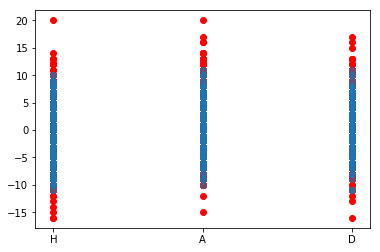

XGBClassifier average accuracy for cross-validation test set is 0.516


In [33]:
X = X_train.copy()
y = y_train.copy()
X['FTR'] = y
print("Numbers of rows before removing outliers : ",len(X))
X = remove_outliers_for_FTR(X)
print("Numbers of rows after removing outliers : ",len(X))
print_example_scatter(df,X)
y = X['FTR']

X = X[X.columns.difference(['FTR'])]

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

In [34]:
correlation_columns = ['DP20','DP30','DP38','GD10','GD20','GD30','GD38','LSTPD']
X = X_train.copy()
y = y_train.copy()
X = X[correlation_columns]

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.522


In [35]:
X = X_train.copy()
y = y_train.copy()

X,rfe = get_RFE_features(LogisticRegression(),X,y,df_copy,10)

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

[126  58  83 125  66  72   1  69   1  61   1  89   1  70  35  47   6  48
   5  95   9 122   1  97  17  41   4  42  63 100  33  56  32  53  57  52
  55  59  27 114  23  87  18 106   1  60   7 105 112  54 115  36  93   1
  88  16  90   1  75  49  37  28  38  29  73  62  76  94 120 121  84  19
  98  39 116  21  92  22  99  31 124 113  24  85  13  86  65  91   2  81
  40 111  11  71  80  44   3  43  14 108  10 118  20  96  12  77  15  78
  30 107  25  45  64 109 117  50  46 110  26  74   1  68   1  67  34  82
   8 103 101 102  51 104 119  79 123] 

Index(['AGD30w', 'AGD38w', 'AGD5w', 'AGL10w', 'AGS10w', 'AP38w', 'DP30w',
       'DP5w', 'HP20w', 'HP30w'],
      dtype='object') 

XGBClassifier average accuracy for cross-validation test set is 0.489


Optimal number of features: 131
Selected features: ['AF5', 'AGD10', 'AGD10w', 'AGD20', 'AGD20w', 'AGD30', 'AGD30w', 'AGD38', 'AGD38w', 'AGD5', 'AGD5w', 'AGL10', 'AGL10w', 'AGL20', 'AGL20w', 'AGL30', 'AGL30w', 'AGL38', 'AGL38w', 'AGL5', 'AGL5w', 'AGS10', 'AGS10w', 'AGS20', 'AGS20w', 'AGS30', 'AGS30w', 'AGS38', 'AGS38w', 'AGS5', 'AGS5w', 'ALF5', 'ALM1', 'ALM2', 'ALM3', 'ALM4', 'ALM5', 'AP10', 'AP10w', 'AP20', 'AP20w', 'AP30', 'AP30w', 'AP38', 'AP38w', 'AP5', 'AP5w', 'AwayTeam', 'DP10', 'DP10w', 'DP20', 'DP20w', 'DP30', 'DP30w', 'DP38', 'DP38w', 'DP5', 'DP5w', 'DPB10', 'DPB10w', 'DPB20', 'DPB20w', 'DPB30', 'DPB30w', 'DPB5', 'DPB5w', 'Day', 'DaysFromToday', 'GD10', 'GD10w', 'GD20', 'GD20w', 'GD30', 'GD30w', 'GD38', 'GD38w', 'GD5', 'GD5w', 'HF5', 'HGD10', 'HGD10w', 'HGD20', 'HGD20w', 'HGD30w', 'HGD38', 'HGD38w', 'HGD5', 'HGD5w', 'HGL10', 'HGL10w', 'HGL20', 'HGL20w', 'HGL30', 'HGL30w', 'HGL38', 'HGL38w', 'HGL5', 'HGL5w', 'HGS10', 'HGS10w', 'HGS20', 'HGS20w', 'HGS30', 'HGS30w', 'HGS38', 'HGS3

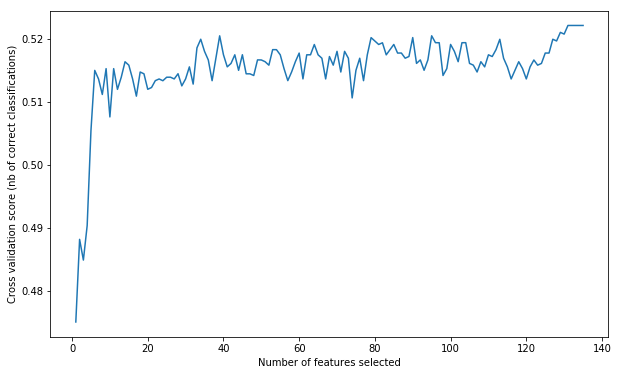

In [11]:
X = X_train.copy()
y = y_train.copy()

rfecv = RFECV(estimator=xgb.XGBClassifier(nthread =-1), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))
rfecv_selected_featues = rfecv.support_
X = X[X.columns[rfecv.support_]]

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', 
                        return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [12]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(nthread =-1)
fit_params={'early_stopping_rounds': 20, 
            'verbose': True,
            'eval_set': [[X, y]]}

scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False,
                        return_estimator=True, n_jobs=-1,fit_params = fit_params)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.517


In [14]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

parameters = {
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'gamma': [0.5, 1, 2, 5],
        'learning_rate':[0.2, 0.3, 0.4, 0.5]
        }

fit_params={'early_stopping_rounds': 20, 
            'verbose': True,
            'eval_set': [[X, y]]}

classifier = xgb.XGBClassifier(nthread =-1)
with HiddenPrints():
    grid_obj = GridSearchCV(classifier,
                            param_grid=parameters,
                             fit_params=fit_params,cv=10,n_jobs=-1, verbose=10 )
    grid_obj.fit(X, y)
    tree_model = grid_obj.best_estimator_

print (grid_obj.best_score_, grid_obj.best_params_) 

In [15]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]


parameters = {  
    "min_child_weight": st.randint(0, 20),
    "gamma": st.randint(0, 10),
    "subsample": st.beta(10, 1),
    "colsample_bytree": st.beta(10, 1),
    "max_depth": st.randint(3, 10),
    "learning_rate": st.uniform(0.05, 0.5)
}

fit_params={'early_stopping_rounds': 20, 
            'eval_set': [[X, y]]}


classifier = xgb.XGBClassifier(nthread =-1)
with HiddenPrints():
    gs = RandomizedSearchCV(classifier,param_distributions =parameters,fit_params=fit_params,cv=10,n_jobs=-1,n_iter=250, verbose=10)  
    gs.fit(X, y)  
    
print (gs.best_score_, gs.best_params_) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  8

0.5320723684210527 {'colsample_bytree': 0.9391478947516567, 'gamma': 8, 'learning_rate': 0.07324342351328968, 'max_depth': 7, 'min_child_weight': 16, 'subsample': 0.9387035928212998}


In [16]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9387035928212998, gamma= 8, min_child_weight= 16, 
                               colsample_bytree= 0.9391478947516567, max_depth= 7,learning_rate=0.07324342351328968,nthread =-1)

# classifier = xgb.XGBClassifier(subsample= 0.8, gamma= 5, min_child_weight= 1, 
#                                colsample_bytree= 0.6, max_depth= 3,learning_rate=0.2,nthread =-1)
fit_params={'early_stopping_rounds': 20, 
            'verbose': True,
            'eval_set': [[X, y]]}

scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False,
                        return_estimator=True, n_jobs=-1,fit_params = fit_params)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.532


In [17]:
df_copy = df.copy()

y = df_copy['FTR']

X = df_copy[df_copy.columns.difference(['FTR'])]
X = X[X.columns[rfecv_selected_featues]]

X = X[X.columns.difference(['FTR'])]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=2019)

In [18]:
classifier = xgb.XGBClassifier(subsample=0.9387035928212998, gamma= 8, min_child_weight= 16, 
                               colsample_bytree= 0.9391478947516567, max_depth= 7,learning_rate=0.07324342351328968,
                               nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 20,verbose= True,eval_set= [[X, y]])

print('Accuracy of logistic regression classifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of logistic regression classifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

[0]	validation_0-merror:0.461404
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.458114
[2]	validation_0-merror:0.459211
[3]	validation_0-merror:0.456579
[4]	validation_0-merror:0.461404
[5]	validation_0-merror:0.459211
[6]	validation_0-merror:0.460307
[7]	validation_0-merror:0.459649
[8]	validation_0-merror:0.458553
[9]	validation_0-merror:0.458553
[10]	validation_0-merror:0.457675
[11]	validation_0-merror:0.45614
[12]	validation_0-merror:0.456579
[13]	validation_0-merror:0.456579
[14]	validation_0-merror:0.455921
[15]	validation_0-merror:0.45614
[16]	validation_0-merror:0.45636
[17]	validation_0-merror:0.454825
[18]	validation_0-merror:0.454167
[19]	validation_0-merror:0.455482
[20]	validation_0-merror:0.454825
[21]	validation_0-merror:0.453947
[22]	validation_0-merror:0.452632
[23]	validation_0-merror:0.45307
[24]	validation_0-merror:0.452851
[25]	validation_0-merror:0.452851
[26]	validation_0-merror:0.453947
[27]	validation_0-merror:0.45

[0]	validation_0-merror:0.473958	validation_1-merror:0.476974
[1]	validation_0-merror:0.464638	validation_1-merror:0.452851
[2]	validation_0-merror:0.461623	validation_1-merror:0.439693
[3]	validation_0-merror:0.457237	validation_1-merror:0.433114
[4]	validation_0-merror:0.456963	validation_1-merror:0.429825
[5]	validation_0-merror:0.458882	validation_1-merror:0.429825
[6]	validation_0-merror:0.457511	validation_1-merror:0.429825
[7]	validation_0-merror:0.457237	validation_1-merror:0.429825
[8]	validation_0-merror:0.455592	validation_1-merror:0.434211
[9]	validation_0-merror:0.455318	validation_1-merror:0.430921
[10]	validation_0-merror:0.454496	validation_1-merror:0.433114
[11]	validation_0-merror:0.453125	validation_1-merror:0.429825
[12]	validation_0-merror:0.452577	validation_1-merror:0.438596
[13]	validation_0-merror:0.453399	validation_1-merror:0.4375
[14]	validation_0-merror:0.451754	validation_1-merror:0.4375
[15]	validation_0-merror:0.452851	validation_1-merror:0.440789
[16]	v

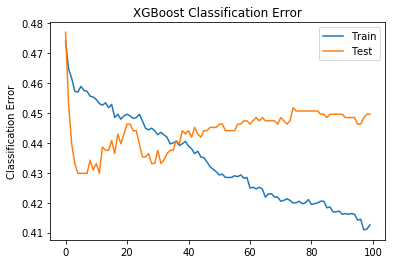

In [19]:
unique = df.FTR.unique()
result_code = dict(zip(unique, range(len(unique))))
def code_FTR(df):
    df = df.applymap(lambda s: result_code.get(s) if s in result_code else s)
    return df

classifier = xgb.XGBClassifier(subsample= 0.8, gamma= 5, min_child_weight= 1, 
                               colsample_bytree= 0.6, max_depth= 3,learning_rate=0.2,nthread =-1)
eval_set = [(X_train, y_train), (X_validation, y_validation)]
classifier.fit(X_train, y_train, eval_metric=["merror"], eval_set=eval_set, verbose=True)

y_pred = classifier.predict(X_validation)

y_pred = DataFrame(y_pred)
y_pred = code_FTR(y_pred)

predictions = [round(value) for value in y_pred]

results = classifier.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [25]:
df_copy = df.copy()

y = df_copy['FTR']

X = df_copy[df_copy.columns.difference(['FTR'])]
X = X[X.columns[rfecv_selected_featues]]

X = X[X.columns.difference(['FTR'])]

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]
X_train = X_train[X_train.columns.difference(['FTR'])]
y_train = df_copy['FTR']

X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
X_validation = X_validation[X_validation.columns.difference(['FTR'])]
y_validation = df_test['FTR']

# X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=2019)

In [29]:
classifier = xgb.XGBClassifier(subsample=0.9387035928212998, gamma= 8, min_child_weight= 16, 
                               colsample_bytree= 0.9391478947516567, max_depth= 7,learning_rate=0.07324342351328968,
                               nthread =-1)
with HiddenPrints():
    classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 20,verbose= True,eval_set= [[X, y]])

print('Accuracy of logistic regression classifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of logistic regression classifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')

Accuracy of logistic regression classifier on test validation set: 0.553
Accuracy of logistic regression classifier on train set: 0.552

 Confusion matrix: 
[[ 57   1  50]
 [ 21   0  78]
 [ 20   0 153]] 



In [39]:
df_copy = df.copy()
df_copy['FTR'] = df_copy['FTR'].str.replace('D','A')

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=2019)

In [40]:
classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.648


In [ ]:
X = X_train.copy()
y = y_train.copy()

rfecv = RFECV(estimator=xgb.XGBClassifier(nthread =-1), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))
rfecv_selected_featues = rfecv.support_
X = X[X.columns[rfecv.support_]]

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', 
                        return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [41]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9387035928212998, gamma= 8, min_child_weight= 16, 
                               colsample_bytree= 0.9391478947516567, max_depth= 7,learning_rate=0.07324342351328968,nthread =-1)
fit_params={'early_stopping_rounds': 20, 
            'verbose': True,
            'eval_set': [[X, y]]}

scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False,
                        return_estimator=True, n_jobs=-1,fit_params = fit_params)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.646


In [42]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=2019)

In [ ]:
X = X_train.copy()
y = y_train.copy()

rfecv = RFECV(estimator=xgb.XGBClassifier(nthread =-1), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))
rfecv_selected_featues = rfecv.support_
X = X[X.columns[rfecv.support_]]

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', 
                        return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [43]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample=0.9387035928212998, gamma= 8, min_child_weight= 16, 
                               colsample_bytree= 0.9391478947516567, max_depth= 7,learning_rate=0.07324342351328968,nthread =-1)
fit_params={'early_stopping_rounds': 20, 
            'verbose': True,
            'eval_set': [[X, y]]}

scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False,
                        return_estimator=True, n_jobs=-1,fit_params = fit_params)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.715


In [46]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]
df_copy = df_copy[df_copy.MW > 5]

df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
y_train = df_copy['FTR']

X_validation = df_test[df_test.columns.difference(['FTR'])]
y_validation = df_test['FTR']

In [ ]:
X = X_train.copy()
y = y_train.copy()

rfecv = RFECV(estimator=xgb.XGBClassifier(nthread =-1), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))
rfecv_selected_featues = rfecv.support_
X = X[X.columns[rfecv.support_]]

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', 
                        return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [81]:
df_copy = df.copy()
df_copy = df_copy[~df_copy.FTR.str.contains('D')]

# X = df_copy[df_copy.columns.difference(['FTR'])]
# y = df_copy['FTR']
# X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=2019)

df_copy = df_copy.sort_values(['Year','Month','Day'], ascending=[False,False,False])

df_test = df_copy.loc[0:379]
df_copy = df_copy.loc[380:]

X_train = df_copy[df_copy.columns.difference(['FTR'])]
X_train = X_train[X_train.columns[rfecv_selected_featues]]
X_train = X_train[X_train.columns.difference(['FTR'])]
y_train = df_copy['FTR']

X_validation = df_test[df_test.columns.difference(['FTR'])]
X_validation = X_validation[X_validation.columns[rfecv_selected_featues]]
X_validation = X_validation[X_validation.columns.difference(['FTR'])]
y_validation = df_test['FTR']

In [83]:
X = X_train.copy()
y = y_train.copy()

rfecv = RFECV(estimator=xgb.XGBClassifier(nthread =-1), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))
rfecv_selected_featues = rfecv.support_
X = X[X.columns[rfecv.support_]]

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', 
                        return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

KeyboardInterrupt: 

In [82]:
classifier = xgb.XGBClassifier(subsample=0.9387035928212998, gamma= 8, min_child_weight= 16, 
                               colsample_bytree= 0.9391478947516567, max_depth= 7,learning_rate=0.07324342351328968,
                               nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 20,verbose= True,eval_set= [[X, y]])

print('Accuracy of logistic regression classifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of logistic regression classifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

ValueError: y contains previously unseen labels: 'D'